In [1]:
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *
from libs.convex_hull import *

from mplsoccer import Pitch
import os
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon

In [2]:
df = compile_team_tracking_data("data/H_EURO2024GERMANY", "Denmark")
df = extract_one_match(df,1)


In [3]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [4]:
def convex_hull(df : pd.DataFrame, regex : str):
    df = df.filter(regex=regex)
    np_data = df.to_numpy()
    points = []
    for row in np_data:
        row = row[~np.isnan(row)]
        points.append(list(zip(row[0::2],row[1::2])))
    hulls = []
    i=0
    for data in points:
        i=i+1

        hulls.append(ConvexHull(data))
    return hulls



In [20]:
from scipy.spatial import ConvexHull
import numpy as np
import pandas as pd

def convex_hull(df: pd.DataFrame, regex: str, num_players: int = None):
    """
    Computes convex hulls for player positions, allowing the selection of a subset of players.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing player positions.
    regex (str): A regex pattern to filter player positions in the DataFrame.
    num_players (int): The number of players to include in the convex hull (optional).
    
    Returns:
    list: A list of ConvexHull objects for each frame of data.
    """
    # Filter columns based on the regex
    df = df.filter(regex=regex)
    np_data = df.to_numpy()  # Convert the DataFrame to a NumPy array
    points = []

    # Process each frame of data to extract player positions
    for row in np_data:
        row = row[~np.isnan(row)]  # Remove NaN values (incomplete player positions)
        player_positions = list(zip(row[0::2], row[1::2]))  # Create (x, y) pairs

        # If num_players is specified, limit the number of players
        if num_players is not None and len(player_positions) > num_players:
            # Sort players by their distance to the center of the field (or other criteria)
            center = np.mean(player_positions, axis=0)  # Calculate the central point (e.g., mean position)
            player_positions = sorted(player_positions, key=lambda pos: np.linalg.norm(np.array(pos) - center))
            player_positions = player_positions[:num_players]  # Select the top N closest players

        points.append(player_positions)

    # Compute convex hulls for each frame
    hulls = []
    for data in points:
        if len(data) >= 3:  # Convex hull requires at least 3 points
            hulls.append(ConvexHull(data))

    return hulls


In [21]:

hulls = convex_hull(df.iloc[::48], "^home", num_players = 11)



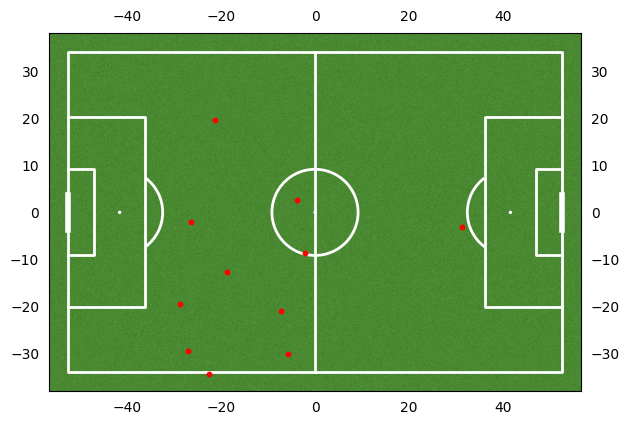

In [22]:

from mplsoccer import Pitch

import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def hull_to_polygon(hull):
    """Convert a scipy ConvexHull object to a shapely Polygon."""
    points = hull.points[hull.vertices]
    return Polygon(points)

def find_centroid(hull):
    """Find the centroid of a ConvexHull."""
    points = hull.points[hull.vertices]
    centroid = np.mean(points, axis=0)
    return centroid

def normalize_hull(hull):
    """Normalize a ConvexHull by centering it around (0, 0)."""
    centroid = find_centroid(hull)
    normalized_points = hull.points - centroid  # Translate points to center around (0, 0)
    return ConvexHull(normalized_points)

def overlapping_area(hull1, hull2):
    """Compute the overlapping area between two convex hulls."""
    poly1 = hull_to_polygon(hull1)
    poly2 = hull_to_polygon(hull2)
    
    if not poly1.intersects(poly2):
        return 0.0
    
    intersection_over_union = poly1.intersection(poly2).area/(poly1.area + poly2.area - poly1.intersection(poly2).area)
    
    return intersection_over_union

def top_n_similar_hulls(target_hull, hull_list, n=10):
    """Find the top n hulls with the largest overlapping area with the target hull."""
    # Normalize the target hull
    target_hull_normalized = normalize_hull(target_hull)
    
    # Calculate the overlapping area for each normalized hull in the list
    areas = [(hull, overlapping_area(target_hull_normalized, normalize_hull(hull))) for hull in hull_list]
    
    # Sort the hulls by the overlapping area in descending order
    areas_sorted = sorted(areas, key=lambda x: x[1], reverse=True)
    
    # Return the top n hulls
    return areas_sorted[:n]

# Example usage




top_10_hulls = top_n_similar_hulls(hulls[150], hulls,100)

football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
football_pitch.draw()  # Draw the pitch on the current axis

plt.scatter(hulls[150].points[:, 0], hulls[150].points[:, 1], color='red', s=10)
plt.show()


In [ ]:

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Create the pitch with the desired settings
for hull, i in zip(top_10_hulls[:10], range(len(top_10_hulls[:10]))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    # Scatter plot for convex hull points
    ax[row, col].scatter(hull[0].points[:, 0], hull[0].points[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()



In [45]:
def ripley_k_for_hulls(hulls):
    radii = np.arange(0, 34)  # Define radii for Ripley's K
    width = 105.0  # Pitch width
    height = 68.0  # Pitch height

    k_vals = []
    
    # Ensure that we are working with the convex hull objects and not tuples
    for hull_tuple in hulls:
        hull = hull_tuple[0]  # Access the actual convex hull object (first element of the tuple)
        
        points = hull.points  # Get player positions from the convex hull
        flattened_points = points.flatten()  # Flatten into 1D array (x_1, y_1, x_2, y_2, ...)
        
        # Calculate Ripley's K for this hull
        k_val = ripley_k(flattened_points, radii, width, height)
        
        k_vals.append(k_val)
    
    return k_vals


In [46]:
# Calculate Ripley's K values for the convex hull situations
ripley_k_vals_hulls = ripley_k_for_hulls(top_10_hulls)

# Perform PCA on the Ripley's K values from the convex hull situations
pca_obj_ripley_hulls = PCAObject(ripley_k_vals_hulls, 10)  # Fit PCA with 10 components
np_pca_ripley_hulls = pca_obj_ripley_hulls.transform(ripley_k_vals_hulls)

# Step 9: Plot the PCA-reduced Ripley's K values for the convex hulls
plt.figure()
plt.scatter(np_pca_ripley_hulls[:, 0], np_pca_ripley_hulls[:, 1])
plt.title("PCA of Ripley's K for Convex Hull Situations")
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [ ]:
# Step 4: Cluster the PCA-reduced Ripley's K values using your KMeansObject
n_clusters = 5  # Choose the number of clusters
clustering_obj_ripley_hulls = KMeansObject(np_pca_ripley_hulls, n_clusters)  # Fit KMeans
labels = clustering_obj_ripley_hulls.get_labels()  # Get the cluster labels

# Step 5: Plot the clustered PCA-reduced Ripley's K values
plt.figure(figsize=(8, 6))
plt.scatter(np_pca_ripley_hulls[:, 0], np_pca_ripley_hulls[:, 1], c=labels, cmap='viridis', marker='o', s=50)
plt.title('Clustered PCA of Ripley K for Convex Hull Situations')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')  # Optional: Add a colorbar to indicate cluster labels
plt.show()


In [ ]:
top_10_hulls[0][0].points

10


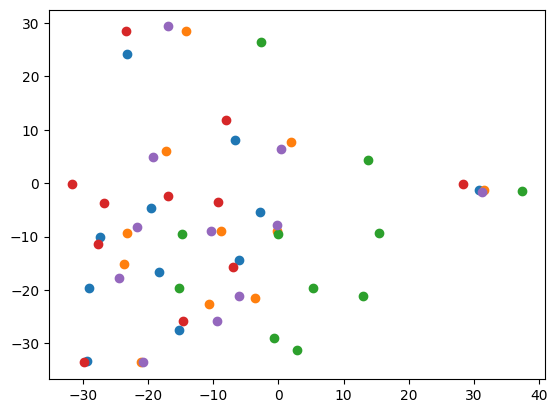

In [16]:
# Create the main directory for clusters
main_folder = "clusters"
os.makedirs(main_folder, exist_ok=True)


# Assuming you have a DataFrame or similar structure that relates each hull to its original data
# For example, top_10_hulls should be indexed or associated with their respective K values.

# Create a dictionary to hold situations by cluster
situations_by_cluster = {i: [] for i in range(n_clusters)}

# Map each situation (hull) to its corresponding cluster label
for idx, label in enumerate(labels):
 
    situations_by_cluster[label].append(top_10_hulls[idx][0].points)  # Append the hull or associated data to the respective cluster


# Assuming you have a dictionary `situations_by_cluster` where each cluster contains multiple situations (hulls)
for cluster, situations in situations_by_cluster.items():
    # Create a subfolder for each cluster
    cluster_folder = os.path.join(main_folder, f"cluster_{cluster}")
    os.makedirs(cluster_folder, exist_ok=True)
    
    # Loop through each situation in the cluster and plot it
    for idx, situation in enumerate(situations):
        # Create a new figure with a soccer pitch background
        fig, ax = plt.subplots(figsize=(10, 7))
        football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                               label=True, line_color="white", pitch_color="grass")
        football_pitch.draw(ax=ax)
        
        # Scatter plot for the convex hull points
        ax.scatter(situation[:, 0], situation[:, 1], color='red', s=50)
        
        # Compute the convex hull for the points
        hull = ConvexHull(situation)
        # Extract the vertices of the hull
        hull_points = situation[hull.vertices]
        
        # Plot the convex hull polygon
        polygon = Polygon(hull_points, closed=True, edgecolor='blue', fill=False, linewidth=2)
        ax.add_patch(polygon)
        
        # Customize the plot (optional)
        plt.title(f'Situation {idx+1} in Cluster {cluster}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        
        # Save the plot in the appropriate cluster folder
        save_path = os.path.join(cluster_folder, f'situation_{idx+1}.png')
        plt.savefig(save_path)
        plt.close()  # Close the plot to avoid displaying it


In [2]:
import os
import vlc
import time

# Path to your video file
video_path = r"C:\Users\Ericd\OneDrive\Dokumenter\GitHub\Thesis_V1\data\video\EURO2020Russia_vs_Denmark_1st_Half_769630.mp4"

# Create an instance of VLC player with stop button
player = vlc.MediaPlayer(video_path) 
player.video_set_mouse_input(False)
player.video_set_key_input(False)

# Play the video
player.play()
# Make a stop button in the vlc


# Keep the player running until the video finishes
duration = player.get_length() / 1000  # Convert milliseconds to seconds
time.sleep(duration)  # Let the video play to its full duration
